In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* 사이킷 런에서 데이터 받아오기

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape # X는 받아오는 데이터 

(70000, 784)

In [4]:
print(X.shape) # X의 정확한 값 label
print(y.shape)

(70000, 784)
(70000,)


Saving figure some_digit_plot


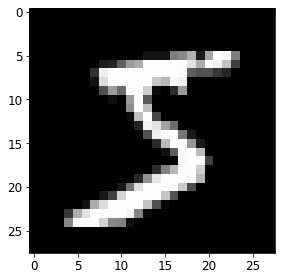

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28) # some_digit = X[0]는 784 한줄로 이루어져 있는데 28크기의 2차원 배열로 바꿔줌
plt.imshow(some_digit_image, cmap='gray') # imshow로 그리고 띄워야 함 그려달라고 했다고 바로 안보여줌
    # cmap : 'gray' 와 같이 색을 일일히 입력해도 되지만 칼라맵(이미 있는 색조합)을 넘길수도 있음
plt.axis("on") # 그린거에 축 추가
save_fig("some_digit_plot") # 이미지 저장
plt.show()

In [6]:
y[0]

'5'

* 실제 레이블과 같음을 확인 할 수 있다.

In [7]:
print(type(y[0]))
y = y.astype(np.uint8) 
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


In [77]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [78]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

* np 는 numpy를 뜻하고 np.unit8 = int
* str -> int로 바뀜

## 데이터 나누기 

* train : test = 6 : 1 

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


## 2진 분류기 ( Binary classifier)

In [9]:
y_train_5 = (y_train == 5) # 5감지기 : 5면 true
y_test_5 = (y_test == 5)

* 5 감지기를 위한 타깃 벡터 만들기

### SGDClassifier 를 사용해 확률적 경사 하강법(SGD) 사용
* 매우 큰 데이터셋을 효율적으로 처리
* 한번에 하나씩 훈련 샘플을 독립적으로 처리 -> 온라인 학습에 적절

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # 무작위성을 띄기 때문에 random 매개변수 작성
sgd_clf.fit(X_train, y_train_5) # 5면 참

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit]) # some_digit = X[0]

array([ True])

## 성능 측정

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") 

array([0.95035, 0.96035, 0.9604 ])

* k - 겹(3개) 교차 검증
    * k를 3개의 폴드로 나누고 각 폴드에 대해 예측을 만들고 평가하기위해 나머지 폴드로 훈련시킬 모델을 사용 그러니까 3번 함
    * 모든 데이터가 최소 한 번은 테스트셋으로 쓰이도록 해야 한다
* sgd_clf 를 사용해 X_train을 넣고 y_train_5 의 값과 맞는지 비교 이떄 cv는 3 , 점수는 정확도로 비교

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


* cross_val_score 를 직접 구현하는 함수이다 위와 값이 동일함 을 알 수 있다.

### 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass # continue는 다음 순번의 loop와 가지만 pass는 그냥 밑에 더이상 코드가 없다는뜻으로 밑 내용이 실행 된다.
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") # never_5_clf 사용

array([0.91125, 0.90855, 0.90915])

* 이미지의 10% 정도만 5이기 때문에 무조건 5 아님으로 예측하면 맞출 확률이 90%이다.
* 정확도를 분류기의 성능 지표로 선호하지 않는 이유
    * 불균형한 데이터셋(클래스가 다른것보다 월등히 많은 경우) 더 심함

### 오차 행렬 (confusion matrix)
* 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세기 
* 실제 타깃과 비교 할 수 있도록 먼저 예측값을 만들어야 함 (test set사용 금지)
    * cross_val_predict()사용


In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

* k겹 교차 검증을 수행하지만 평가 점수를 반화ㅑㄴ하지 않고 각 테스트 폴드에서 얻은 예측을 반환 합니다.

### 정밀도(precision) 과 재현율(recall)
* 정밀도 : TP / (TP + FP)
* 재현율 : TP / (TP + FN)

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # 정밀도

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred) # 재현율

0.6511713705958311

#### F1 점수(F1 Score)
* 정밀도와 재현율을 하나의 숫자로 만들어 관리
* 정밀도와 재현율의 조화 평균
* F1 = 2/(1/정밀도 + 1/ 재현율)
* 정밀도와 재현율이 비슷한 분류기에서는 F1점수가 높다. 
    * 상황에 따라 정밀도가 중요할수도 있고 재현율이 중요할 수도 있다.
        * 어린아이에게 안전한 동영상을 걸러내는 불류기 훈련은 높은 정밀도가 요구됨 나쁜거는 보여주면 안되니까
        * 감시카메라로 좀도둑을 잡아내는 분류기를 훈련시킨 다면 재현율이 높아야됨 도둑은 확실히 찾아야 되기 때문 무죄인 사람을 도둑으로 오해하는 경우가 생기더라도
        * 둘은 Trade-Off이다.

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 정밀도/재현율 트레이드 오프
* 결정함수 (decision function)을 사용하여 샘플의 점수를 계산한다.
* 위 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다.
* 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 할 수 있다. 

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

array([ True])

* SGD의 임계값은 0이기 때문에 true가 된다.

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

* 임계값을 높이면 False가 나온다.
* 즉 정밀도가 높아지고 재현율이 낮아진다. 

#### 적절한 임곗값 정하기

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

* cross_val_predict() 함수를 이용해 훈련세트에 있는 결과가 아닌 모든 셈플의 점수를 구한다. 
* 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산 할 수 있다.

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


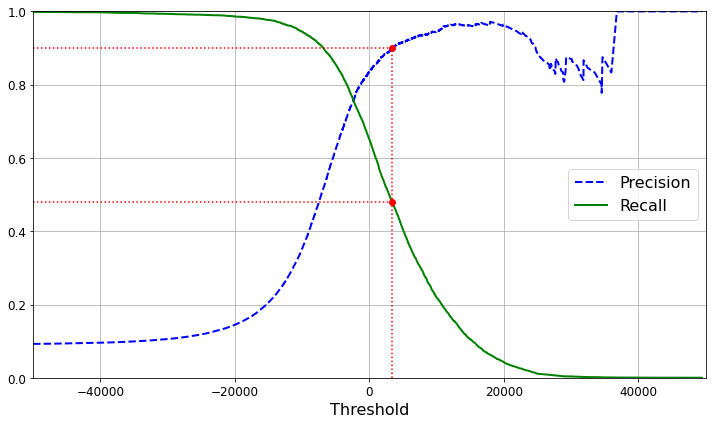

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):  # threshods 결정 임계값 F1 값
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # "b--"는  파랑색 dashed line style
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)        # "g-" 는 초록색 solid line style 
    # https://datascienceschool.net/view-notebook/d0b1637803754bb083b5722c9f2209d0/     plt.plot 에 대한 추가 링크
    plt.legend(loc="center right", fontsize=16) # 선들의 정보를 나타내는 박스에 대한 위치
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             # x축 시작과 끝 y축 시작과 끝



recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # np 는 numpy
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(10, 6))                                                                 # 그래프 사이즈 조절
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)                         # 위에서 만든 함수 실행
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 #  x 범위 y범위 선 정보
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # "r" red - dotted line style
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")#  k : black
plt.plot([threshold_90_precision], [0.9], "ro")                                             #  빨강 점
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              # 저장
plt.show()

* 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문에 (일반적으로 높아져야 한다.) 정밀도 곡선이 울퉁불퉁 해 질수 있다. 

In [27]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


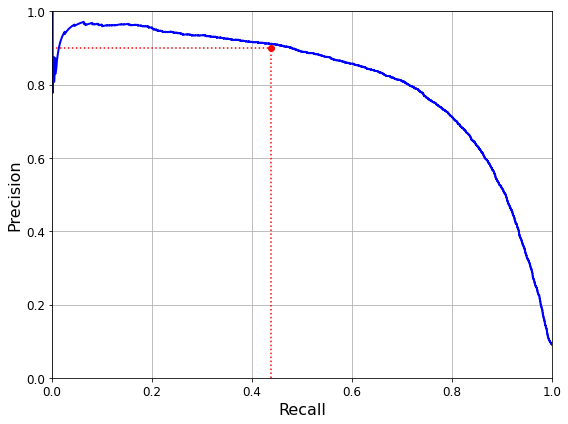

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

* 재현율에 대한 정밀도 그래프
* 재현율 80% 근처에서 정밀도가 급격하게 줄어든다. 이 하강점 직전을 trade-off로 설택하는것이 좋다. (ex 60 %)

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

* 정밀도 90이상을 달성하는게 목적일경우 
* argmax는 최대값의 첫번째 인덱스를 반환 ( upper_bound)

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC 곡선
* 수신기 조작 특성(receiver operataing charactericstic) 곡선도 이진 분류에서 널리 사용하는 도구 이다.
* 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR : 재현율)의 곡선이다.
    * 1에서 진짜 음성 비율(TNR)를 뺸 값 TNR은 특이도(Specificity)라고도 한다.
* ROC 곡선은 민감도에 대한 1 - 특이도 그래프이다. 

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

* roc_curve() 함수를 이용해 여러 임계값에서 TPR과 FPR을 계산한다.

In [35]:
print(fpr.shape, tpr.shape, thresholds.shape)

(3908,) (3908,) (3908,)


Saving figure roc_curve_plot


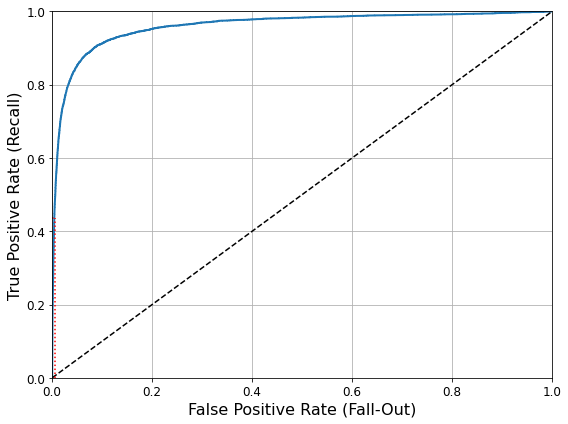

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)              # x 와 y 에대한 그래프이기 때문에 label=label
    plt.plot([0, 1], [0, 1], 'k--')                           # 대각점선
    plt.axis([0, 1, 0, 1])                                    # 축 범위
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
#plt.plot([4.837e-3], [0.4368], "ro")               
save_fig("roc_curve_plot")                         
plt.show()

* TPR에 대한 FPR 곡선
* TPR이 높을수록 FPR이 늘어난다. 
* 점선은 완전한 랜덤 분류기의 ROC곡선(그냥 찍는거)  왼쪽 위 모서리로 멀어질 수록 좋은거 

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* 곡선 아래의 면적(area under the curve : AUC) 를 측정하면 분류기 비교를 할 수 있다. 완벽한 분류기는 1이고 완전한 랜덤은 0.5이다.
* ROC 곡선이 정밀도 / 재현율 곡선과 비슷해서 무엇을 사용해야할지 궁금 할 수 있다. 일반적으로는 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않으면 ROC 사용

* RandomForestClassifier 를 훈련시켜서 SGD분류기의 Roc곡선과 ROC AUC 점수를 비교 한다.
* 훈련 세트의 샘플에 대한 점수를 얻어여 하는데 RandomForestClassifier 에는 decision_function() 메서드가 없지만 predict_proba()가 있다.
* sklearn 분류기는 일반적으로 이 두 메서드중 1개 | 2모두를 가지고 있다. 
* predict_proba() 메서드는 샘플이 행, 클래스가 열 이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환 한다. 

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [42]:
y_scores_forest = y_probas_forest[:, 1] # 양성클래스에 대한 확률을 점수로 사용한다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

* roc_curve()함수는 레이블과 점수를 기대한다. 하지만 점수 대신에 클래스 확률을 전달 할 수 있다. 

Saving figure roc_curve_comparison_plot


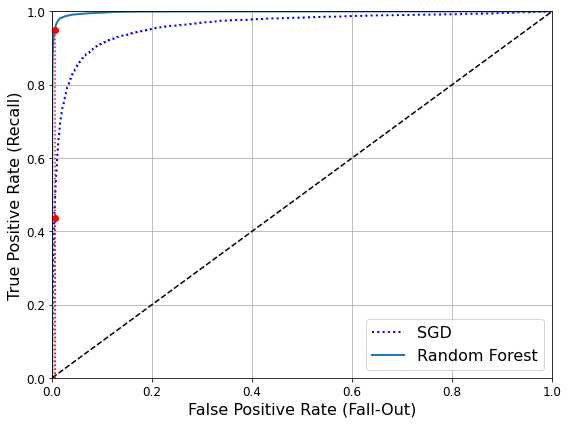

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth= 2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

* Random Forest의 ROC 곡선이 왼쪽 위 모서리에 더 가깝다.

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [49]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3) # 이게 오래 걸림
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

* 정밀도

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

* 재현율

## 다중 분류(Multiclass classification)
* 둘 이상의 클래스를 구별 한다.
* 여러 개의 클래스를 직접 처리 할 수 있는 알고리즘
    * SGD , rnadom - forest , naive Bayes
* 이진 분류만 가능
    * 로지스틱 회귀, 서포트 벡터 머신 분류기
* 하지만 이진 분류기를 여러개 사용해 다중 클래스를 분류하는 기법도 많다.
    * 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개 (0~9)를 훈련 시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다. 
    * 각 분류기의 결정 점수중에서 가장 높은것을 클래스로 선택하면 된다. 
    * OvR 전략(one-versus-the-rest) 혹은 OvA(one-versus-all)라고도 한다.
    * 또 다른 전략은 0과 1구별 0과 2 구별 1과 2 구별과 같이 각 숫자들의 조합마다 이진 분류기를 훈련시키는 OvO(one-versus-one)이 있다.
        * 클래스가 N개변 N*(N-1)/2개의 분류기가 필요하다. 
        * MNIST에서는 45개의 분류기를 모두 통과 시켜서 가장 많이 양성으로 분류된 클래스를 선택 한다. 
        * 각 분류기의 훈련에 전체 훈련 세트중 구별할 두 클래스에 해당하는 샘플만 필요하다.
    * 서포트 벡터 머신같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 작은 훈련 세트에서 많은 분류기를 훈련시키는것이 빠르므로 OvO를 선호 한다. 
    * 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호한다.
* 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 sklearn이 알고리즘에 따라 OvR 혹은 OvO를 실행 한다.

In [51]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5 이 아니라 y_train사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

* y_train_5 대신 0~9까지의 운래 타깃 클래스(y_train)을 사용해 SVC를 훈련 시킨다. 
* sklearn이 OvO전략을 사용해 10개의 이진 분류기를 훈련 시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를  선택한다.

In [52]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

* some_digit의 10개의 클래스에대한 점수를 반환

In [53]:
np.argmax(some_digit_scores)

5

In [54]:
svm_clf.classes_ # 0부터 시작한다.

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
svm_clf.classes_[5]

5

In [ ]:
* 분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장한다.
* 위에는 0->0 , 5->5와 같이 인덱스와 클래스 값 자체가 같지만 드문 경우 이다. 

* sklearn 에서 OvO나 OvR을 사용하도록 강제하려면  OneVsRestClassifier 나 oneVsRestClassifier를 사용한다.
* 간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 된다. 

In [56]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

* SVC 기반으로 OvR 전략을 사용하는 다중 분류기를 만든다.

In [57]:
len(ovr_clf.estimators_)

10

In [58]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

* Sgd_clf를 훈련시키기
* SGD_clf는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 sklearn의 OvR이나 OvO를 적용할 필요가 없다. 

In [59]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

* decision_function() 메서드는 클래스마다 하나의 값을 반환 한다. 
* 이 결과에서 5가 큰 양수가 나와야되는데 3만 큰 양수가 나와 버렸다.... 이러면 안되는데 뭐지

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

* 모든 테스트 폴드에서 87의 정확도를 보여줬다 ;;

In [64]:
 from sklearn.preprocessing import StandardScaler
 scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # 사전 작업함
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

* 위의 코드는 2장에서 처럼 입력의 스케일링을 조절하여 정확도를 높일수 있는 방법인데 오래 걸려서 실행은 안하고 주석 처리만 하였다.

## 에러 분석
* 실제 프로젝트라면 데이터 준비 단계에서 선택 사항을 탐색하고, 여러 머델을 시도하고, 가장 좋은 몇 개를 골라 GridSearchCv를 사용해 하이퍼 파라미터를 세밀하게 튜닝하한다. (가능한 자동화)
* 간으성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아본다.
    * 한가지 방법은 만들어진 에러의 종류의 분석하는 것이다.

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

* cross_val_predict() 함수를 사용해 예측을 만들고 confusion_matrix() 함수 호출

In [66]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


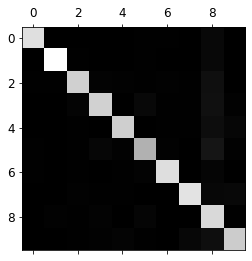

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

* 주대각선에 이미지가 올바르게 분류 되었음을 나타내는 정보가 있다.  (흰색이 가장 큰값, 검은색이 작은값)
* 5는 상대적으로 어두운데 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다. 
* 두경우 모두 확인해 봐야 한다.

* 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나눠 에러 비율을 비교한다.
    * MNIST는 클래스별 이미지개수가 동일하지 않다.

In [74]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)

norm_conf_mx = conf_mx / row_sums
print(norm_conf_mx.shape)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]
(10, 10)


* 행의 합으로 다 나눴는데 왜그랬을까...크기 단위를 맞추려고? 비율을로 하려고?

Saving figure confusion_matrix_errors_plot


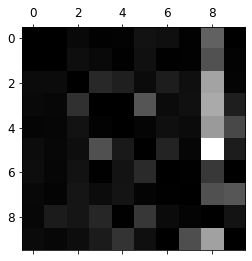

[[0.         0.         0.00371433 0.00084417 0.00135067 0.00725983
  0.006078   0.001013   0.03798751 0.00016883]
 [0.         0.         0.00548799 0.00355977 0.0005933  0.00652625
  0.0005933  0.00103827 0.03144468 0.00148324]
 [0.00453172 0.00453172 0.         0.01544142 0.01225243 0.00453172
  0.01124538 0.0060423  0.06344411 0.00184626]
 [0.00358832 0.00277279 0.01908335 0.         0.00032621 0.03311042
  0.00440385 0.00652422 0.06573153 0.0119067 ]
 [0.00205409 0.00239644 0.00701814 0.00154057 0.         0.00205409
  0.00581992 0.0046217  0.05939747 0.02807258]
 [0.00498063 0.00276702 0.00553403 0.03099059 0.00977679 0.
  0.01383509 0.00258255 0.09869028 0.01106807]
 [0.00506928 0.00253464 0.00709699 0.00050693 0.00743494 0.01639067
  0.         0.00050693 0.02213586 0.00016898]
 [0.00335196 0.00159617 0.00814046 0.00478851 0.00782123 0.0019154
  0.00047885 0.         0.0311253  0.03351955]
 [0.00290549 0.01076739 0.00820373 0.01469834 0.00051273 0.02153478
  0.00427277 0.001709

In [75]:
np.fill_diagonal(norm_conf_mx, 0) # 대각선 상수값 0으로 변경
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

* class 8 의 열이 상당히 밝은데 이는 많은 이미지가 8로 잘못 분류되었음을 암시한다. 
* 반대로 class 8의 행은 그리 나쁘지 않은데 이는 실제 8이 적절히 8로 갔음을 알려준다.
* 오차행렬이 반드시 대칭인 것은 아니다.
* 3과 5가 서로 많이 혼란이 있는거도 알 수 있다.

* 8처럼 보이지만 (실제로 8 아님) 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있다.
* 분류기에 도움 될 만한 특성을 더 찾아볼 수 있다. 
    * 동심원의 수를 세는 알고리즘(8 : 2개 , 6,0 은 1개,..)
    * 동심원 같은 어떤 패턴이 드러나도록 이미지를 전처리 할 수도 있다.
* 개개의 에러를 분석해보면 분류기가 무슨 일을하고 왜 잘못 되었는지 알 수도 있지만 어렵고 시간이 오래 걸린다. 

### 3과 5의 샘플

(5227, 784) (203, 784) (168, 784) (4444, 784)
Saving figure error_analysis_digits_plot


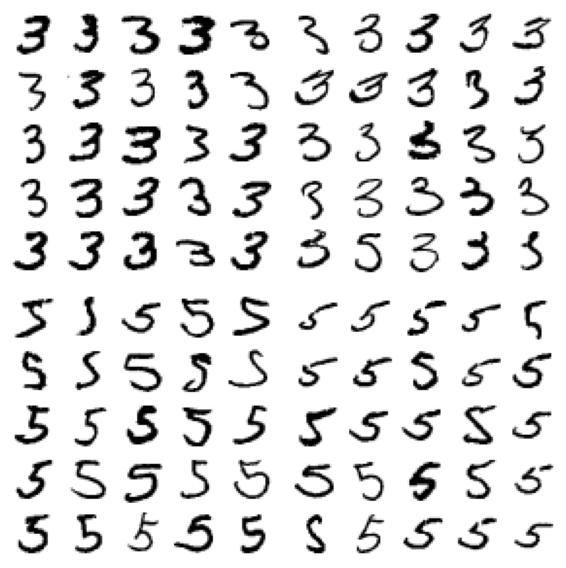

In [80]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3인데 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3인데 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5인데 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] #5인데 5

print(X_aa.shape, X_ab.shape,X_ba.shape,X_bb.shape)

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) #plot_digits 위에서 정의한 그려주는 함수
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) 
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

* 사람이 봐도 솔직히 분류하기가 어려운 경우가 있다.
* 분류기가 실수한 이유를 이해하기 어렵다.
* 원인은 선형 모델인 SGD_clf를 사용했기 때문이다.
    * 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다.
    * 3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동한다.
* 3과 5의 주요차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치이다.
     * 연결부위가 왼쪽이면 5가되고 오른쪽이면 3이 된다. 
 * 분류기는 이미지의 위치나 회전 방향에 매우 민감하다.
     * 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 할 수 있다. 

## 다중 레이블 분류(Multilabel classification)
* 지금 까지는 각 샘플이 하나의 클래스에만 할당되었지만 분류기가 샘플마다 여러개의 클래스를 출력해야 할 때도 있다. 
    * 얼굴 인식 분류기의 경우 같은 사진에 여러 사람이 등장한다면 인식된 사람마다 하나씩 tag를 붙여야 한다. 
    * 분류기가 진현, 상일 , 지효 세 얼굴을 인식하도록 훈련되었다고 가정해보자
    * 진현 지효가 있는 사진을 보면 [1,0,1]을 출력 해야 한다.

In [81]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

* 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다. 
* 첫번째는 숫자가 큰값 (7, 8,9)인지 나타내고 두번째는 홀수인지 나타낸다
* 그 다음줄은 KNeighborsClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련시킨다. 
* 결정 트리, 랜덤 포레스트, OneVsRestClassifier에서도 다중 레이블 분류를 지원한다.

In [83]:
knn_clf.predict([some_digit])

array([[False,  True]])

* 5는 7미만인 홀수 이다.

* 다중 레이블 분류기를 평가하는 방법은 많지만 적절한 지표는 프로젝트에 따라 다르다.
    * 각 레이블의 F1점수를 구하고 간단하게 평균 점수를 계산한다. 

In [85]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 0.976410265560605 

* 위 코드는 한시간정도의 시간이 걸린다. 
* 모든 레이블에 대한 F1점수의 평균을 계산한다. 
* 위 코드는 모든 레이블의 가중치가 같다고 가정 한 것이다. 
    * 진현의 사진이 상일이나 지효의 사진보다 훨 씬 많다면 진현의 사진에 대한 분류기의 점수에 더 높은 가중치를 둘 것이다. 
* 간단한 방법은 레이블에 클래스의 지지도( 타깃 레이블에 속한 샘플수)를 가중치로 두는 것이다. 
    * 위 코드에서 average = "weighted" 로 설정하면 된다.

## 다중 출력 분류 (Multioutput classification)
* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될수 있도록 일반화한 것이다. (값을 2개이상 가질 수 있다.)
* 이미지에서 잡음을 제거하는 시스템을 만들어 보자
* 잡음이 많은 숫자 이미지를 입력으로 받고 깨긋한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력한다.
* 분류기의 출력이 다중 레이블 (픽셀당 한 레이블로 침)이고 각 레이블은 값을 여러개 가진다. (0~255)
* 위와 같은 경우 처럼 분류와 회귀 사이의 경계는 때때로 모호하다. 픽셀 강도 예측은 분류보다 회귀와 비슷하다. 더욱이 출력 시스템이 분류작업에 국한되지도 않는다. 따라서 샘플마다 클래스와 값을 모두 포함하는 다중 레이블이 출력되는 시스템도 가능하다. 

In [86]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

* MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randit() 함수를 사용해 픽셀 강도에 잡을울 추가 할 수 있다. 

Saving figure noisy_digit_example_plot


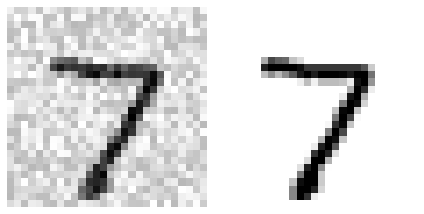

In [87]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

* 왼쪽이 잡음 섞인 이미지고 오른쪽이 깨끗한 이미지

Saving figure cleaned_digit_example_plot


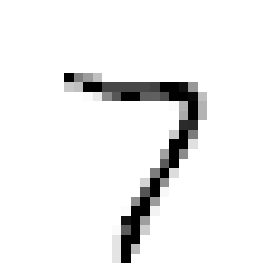

In [88]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

* 분류기를 학습 시키고 수정한 이미지